**2.Load a stereo audio file of your choice.**

In [65]:
import librosa

#parameter mono = False ： Do not convert signal to mono
x, sr = librosa.load('/content/demo1.wav',mono = False, duration = 10.0,sr = None)

**3.Implement Prof. Schuller’s Convolutional Autoencoder in the Colab Notebook.**

In [66]:
#import
import torch
import torch.nn as nn
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import IPython.display as ipd

#Device configuration:
if torch.cuda.is_available():
	device = torch.device('cuda')
else:
	device = torch.device('cpu')
 
print('Device = ',device)

Device =  cpu


In [67]:
def signal2pytorch(x):
  #Function to convert a signal vector s, like a mono audio signal, into a 3-d Tensor that conv1d of Pytorch expects,
  #https://pytorch.org/docs/stable/nn.html
  #conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals) 
  #Argument x: a 1-d signal as numpy array
  #output: 3-d Tensor X for conv1d input.
  X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
  X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
  X = torch.from_numpy(X)
  X = X.type(torch.Tensor)
  return X

class Convautoenc(nn.Module):
  def __init__(self):
    super(Convautoenc, self).__init__()
    #Analysis Filterbank
    #N = 1024, filter length = 2N, output = N/2
    #padding = kenen_lsize/2-1
    self.conv1 = nn.Conv1d(in_channels = 1, out_channels = 32, kernel_size = 2048, stride = 1024, padding = 1023, bias = True)

    #synthesis Filterbank:
    self.synconv1 = nn.ConvTranspose1d(in_channels = 32, out_channels = 1, kernel_size = 2048, stride = 1024, padding = 1023, bias = True)
  
  def encoder(self, x):
    #Analysis:
    x = self.conv1(x)
    y = torch.tanh(x)
    return y

  def decoder(self, y):
    #Synthesis:
    xrek = self.synconv1(y)
    return xrek

  def forward(self, x):
    y = self.encoder(x)
    xrek = self.decoder(y)
    return xrek

In [68]:
if __name__ == '__main__':
  batch = 1

  x, sr = librosa.load('/content/demo1.wav', mono = True , duration = 10.0 , sr = None)
  
  #Normalize:
  x = x / np.max(x)
  print(np.shape(x))

  X = signal2pytorch(x).to(device)
  
  model = Convautoenc().to(device)
  print('Generate Model: ',model)
  print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
  
  loss_fn = nn.MSELoss()  #MSE
  #loss_fn = nn.L1Loss()
  print("Def. loss function: ",loss_fn)
  
  print(np.shape(x))

  Ypred = model(X)

  outputlen = len(Ypred[0, 0, :])
  print('outputlen=' , outputlen)

  Y = X[:,:,:outputlen]

  print("Input X.shape=" , X.shape)
  print("Target Y.shape=" , Y.shape)
  print("Target Y=" , Y)
  #print("max(max(Y))=", max(max(max(Y))))
  #print("min(min(Y))=", min(min(min(Y))))
  print("Y.type()=" , Y.type())
  
  learning_rate = 1e-4
  optimizer = torch.optim.Adam(model.parameters() , lr = learning_rate)
  print('Optimizer: ' , optimizer)
  
  Ypred=model(X)
  #Ypred=Ypred.detach()
  print("Ypred=" , Ypred)

(441000,)
Generate Model:  Convautoenc(
  (conv1): Conv1d(1, 32, kernel_size=(2048,), stride=(1024,), padding=(1023,))
  (synconv1): ConvTranspose1d(32, 1, kernel_size=(2048,), stride=(1024,), padding=(1023,))
)
Total number of parameters: 131105
Def. loss function:  MSELoss()
(441000,)
outputlen= 440322
Input X.shape= torch.Size([1, 1, 441000])
Target Y.shape= torch.Size([1, 1, 440322])
Target Y= tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.1759, 0.1950, 0.2135]]])
Y.type()= torch.FloatTensor
Optimizer:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
Ypred= tensor([[[0.0120, 0.0250, 0.0210,  ..., 0.0150, 0.0206, 0.0190]]],
       grad_fn=<SqueezeBackward1>)


0 0.03735093027353287
100 0.021692434325814247
200 0.012934686616063118
300 0.008500752039253712
400 0.006315659731626511
500 0.004959343001246452
600 0.004020173568278551
700 0.0033390570897608995
800 0.0028305519372224808
900 0.002450178377330303
1000 0.0021629976108670235
1100 0.0019374119583517313
1200 0.0017536386149004102
1300 0.0016012439737096429
1400 0.0014737306628376245
1500 0.001366117037832737
1600 0.0012745187850669026
1700 0.0011960753472521901
1800 0.0011286585358902812
1900 0.0010705377208068967
ww =  OrderedDict([('conv1.weight', tensor([[[ 0.0628,  0.0572,  0.0383,  ..., -0.0075, -0.0268,  0.0102]],

        [[ 0.0510,  0.0379,  0.0265,  ...,  0.0447,  0.0437,  0.0283]],

        [[ 0.0122,  0.0230,  0.0128,  ..., -0.0273, -0.0233, -0.0183]],

        ...,

        [[-0.0093,  0.0162,  0.0129,  ..., -0.0030,  0.0067, -0.0245]],

        [[-0.0650, -0.0764, -0.0328,  ...,  0.0041, -0.0106, -0.0095]],

        [[-0.0290,  0.0055, -0.0225,  ...,  0.0347,  0.0583,  0.051

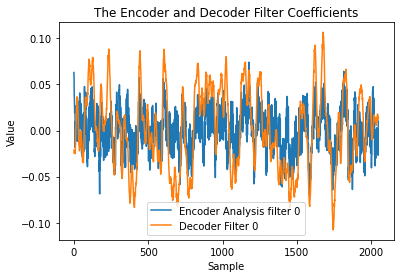

In [69]:
for epoch in range(2000):
    Ypred = model(X)
    loss = loss_fn(Ypred , Y)

    if epoch % 100 == 0:
      print(epoch , loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

ww = model.state_dict()   #read obtained weights
print("ww = " , ww)

#Plot obtained weights:
plt.plot(np.transpose(np.array(ww['conv1.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Encoder and Decoder Filter Coefficients')
plt.show()
    

Test on Trainging set:

predictions.shape= (1, 1, 440322)


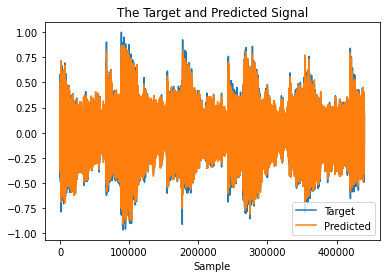

In [70]:
pred=model(X).cpu() # Make Predictions based on the obtained weights, on training set
pred=pred.detach()
pred=np.array(pred)
Y=np.array(Y) #target

print("predictions.shape=" , pred.shape)
#convert to numpy:
#https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2
#Plot target signal and output of autoencoder:
for b in range(batch):
    plt.plot(np.array(Y[b , 0 , :]))
    plt.plot(pred[b , 0 , :])
    plt.legend(('Target','Predicted'))
    plt.title('The Target and Predicted Signal')
    plt.xlabel('Sample')
    plt.show()
xrek=pred[: , 0 , :]  #remove unnecessary dimension for playback
xrek=np.transpose(xrek)
xrek=np.clip(xrek , -1.0 , 1.0)


sf.write('test1rek.wav',xrek, sr)

ipd.Audio('/content/test1rek.wav')

Test on Verification set;

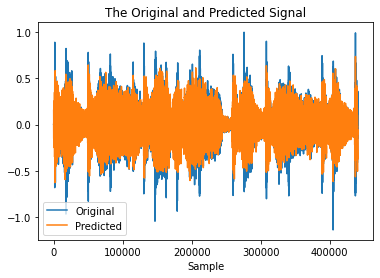

In [71]:
x ,sr = librosa.load('/content/demo2.wav' , mono = True , duration = 10.0 , sr = None)

x = x / np.max(x)

X=signal2pytorch(x).to(device)
predictions=model(X).cpu() # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)

for b in range(batch):
    plt.plot(np.array(X[b , 0 , :]))
    plt.plot(predictions[b , 0 , :])
    plt.legend(('Original','Predicted'))
    plt.title('The Original and Predicted Signal')
    plt.xlabel('Sample')
    plt.show()

xrek=predictions[: , 0 , :]
xrek=np.transpose(xrek)
xrek=np.clip(xrek , -1.0 , 1.0)

sf.write('test2rek.wav' , xrek , sr)
ipd.Audio('/content/test2rek.wav')

Test on shifted input:

In [72]:
x , sr = librosa.load('/content/demo1.wav', mono = True , duration = 10.0 , sr = None)

x = x / np.max(x)

x=np.append(np.zeros(100) , x) #prepend zeros to test time or shift invariance
X=signal2pytorch(x).to(device)
predictions=model(X).cpu() # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
xrek=predictions[: , 0 , :]
xrek=np.transpose(xrek)
xrek=np.clip(xrek , -1.0 , 1.0)

sf.write('test3rek.wav', xrek , sr)
ipd.Audio('/content/test3rek.wav')


Test on 1024 samples shifted test set(shift identical to the stride size)

In [73]:
x, sr = librosa.load('/content/demo1.wav' , mono = True , duration = 10.0 , sr = None)


x=x / np.max(x)

x=np.append(np.zeros(1024),x) #prepend zeros to test time or shift invariance
X=signal2pytorch(x).to(device)
predictions=model(X).cpu() # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
xrek=predictions[: , 0 , :]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0 , 1.0)

sf.write('test4rek.wav', xrek , sr)
ipd.Audio('/content/test4rek.wav')

**4.Train the Convolutional Autoencoder model with one channel of the audio file (for example the Left channel).**

In [74]:
x, sr = librosa.load('/content/demo1.wav' , mono = False , duration = 10.0 , sr = None)
print(np.shape(x))
x_l = x[0 , :]  #make it mono left channel
x_r = x[1 , :]  #make it mono right channel

#normalize
x_l = x_l / np.max(x_l)
x_r = x_r / np.max(x_r)

print(np.shape(x_l))
print(np.shape(x_r))


(2, 441000)
(441000,)
(441000,)


In [75]:
if __name__ == '__main__':
  batch = 1
 
  x = x_l #convert input into x_l

  X = signal2pytorch(x).to(device)
  
  model = Convautoenc().to(device)
  print('Generate Model: ' , model)
  print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
  
  loss_fn = nn.MSELoss()  #MSE
  #loss_fn = nn.L1Loss()
  print("Def. loss function: " , loss_fn)
  
  print(np.shape(x))

  Ypred = model(X)

  outputlen = len(Ypred[0 , 0 , :])
  print('outputlen=' , outputlen)

  Y = X[: , : , :outputlen]

  print("Input X.shape=" , X.shape )
  print("Target Y.shape=" , Y.shape)
  print("Target Y=", Y)
  #print("max(max(Y))=", max(max(max(Y))))
  #print("min(min(Y))=", min(min(min(Y))))
  print("Y.type()=" , Y.type())
  
  learning_rate = 1e-4
  optimizer = torch.optim.Adam(model.parameters() , lr=learning_rate)
  print('Optimizer: ' , optimizer)
  
  Ypred=model(X)
  #Ypred=Ypred.detach()
  print("Ypred=" , Ypred)

Generate Model:  Convautoenc(
  (conv1): Conv1d(1, 32, kernel_size=(2048,), stride=(1024,), padding=(1023,))
  (synconv1): ConvTranspose1d(32, 1, kernel_size=(2048,), stride=(1024,), padding=(1023,))
)
Total number of parameters: 131105
Def. loss function:  MSELoss()
(441000,)
outputlen= 440322
Input X.shape= torch.Size([1, 1, 441000])
Target Y.shape= torch.Size([1, 1, 440322])
Target Y= tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.2006, 0.2212, 0.2412]]])
Y.type()= torch.FloatTensor
Optimizer:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
Ypred= tensor([[[-0.0224, -0.0223, -0.0132,  ..., -0.0106, -0.0268, -0.0051]]],
       grad_fn=<SqueezeBackward1>)


In [76]:
loss_value = []
for epoch in range(2000):
    Ypred = model(X)
    loss = loss_fn(Ypred , Y)
    loss_value.append(loss.item())

    if epoch % 100 == 0:
      print(epoch , loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()  

0 0.048585064709186554
100 0.024968164041638374
200 0.016711018979549408
300 0.011854506097733974
400 0.00860656052827835
500 0.006554420106112957
600 0.005192055366933346
700 0.004222580697387457
800 0.0035270624794065952
900 0.003020625561475754
1000 0.0026413165032863617
1100 0.0023481023963540792
1200 0.002115076407790184
1300 0.001925240852870047
1400 0.0017670601373538375
1500 0.0016330690123140812
1600 0.001518528675660491
1700 0.0014201782178133726
1800 0.001335426582954824
1900 0.0012620065826922655


**5.Plot a graph with the number of epochs in the x axis and the training loss in the y-axis.**

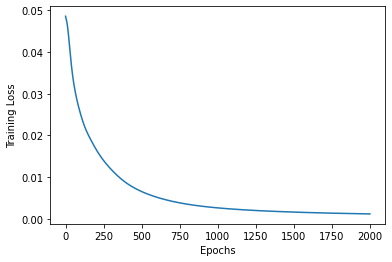

In [77]:
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.plot(loss_value)
plt.show()

**6.Infer (test) the model with the other channel of the audio file (for example if you used the Left channel now you will use the Right channel).**

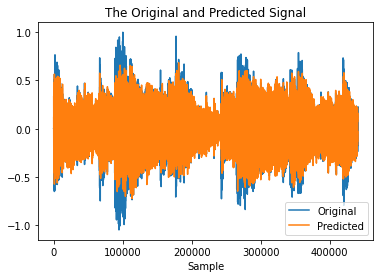

In [78]:
x = x_r #convert input into x_r

X=signal2pytorch(x).to(device)
predictions=model(X).cpu()
predictions=predictions.detach()
predictions=np.array(predictions)

for b in range(batch):
    plt.plot(np.array(X[b , 0 , :]))
    plt.plot(predictions[b , 0 , :])
    plt.legend(('Original' , 'Predicted'))
    plt.title('The Original and Predicted Signal')
    plt.xlabel('Sample')
    plt.show()
xrek=predictions[: , 0 , :]
xrek=np.transpose(xrek)
xrek=np.clip(xrek , -1.0 , 1.0)


**7.Playback the output of the model in the notebook so we can listen how the reconstructed audio signal sounds.**

In [79]:
sf.write('testxrrek.wav' , xrek , sr)
ipd.Audio('/content/testxrrek.wav')

**8.Calculate the mean squared error between the original test audio signal, and the predicted (the reconstructed) audio signal.**

In [80]:
xrek = np.ravel(xrek)
xrek = xrek[0 : 440000]
x_r = x_r[0 : 440000]

MSE = np.sum(np.power((xrek - x_r) , 2))/440000
print('MSE = ' , MSE)




MSE =  0.00570008544921875
